<a href="https://colab.research.google.com/github/Amirhossein2034/First_Script/blob/main/HomeWork2_ML%26Applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Upload & Load ARFF File

In [1]:
from google.colab import files
import pandas as pd

# Upload the ARFF file manually
uploaded = files.upload()

# Identify uploaded filename
filename = list(uploaded.keys())[0]

# Read manually from ARFF file (skip header)
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'target'
]

# Read the data lines after @data
lines = []
with open(filename, "r") as f:
    start = False
    for line in f:
        if line.strip().lower() == "@data":
            start = True
            continue
        if start:
            lines.append(line.strip())

# Split into DataFrame
rows = [line.split(",") for line in lines]
df = pd.DataFrame(rows, columns=column_names)

# Binary label: 0 = normal, 1 = anomaly
df["label"] = df["target"].apply(lambda x: 0 if x.strip() == "normal" else 1)

df.head()


Saving KDDTrain+_20Percent.arff to KDDTrain+_20Percent.arff


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,0


##Preprocessing: One-hot Encoding + Scaling

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

X = df.drop(columns=["target", "label"])
y = df["label"]

# Reduce unique values for 'service' to top 10
top_services = X["service"].value_counts().nlargest(10).index
X["service"] = np.where(X["service"].isin(top_services), X["service"], "other")

# Define columns
categorical = ["protocol_type", "service", "flag"]
numerical = X.columns.difference(categorical)

# ✅ Fixed 'sparse_output' instead of 'sparse'
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical)
])

X_processed = preprocessor.fit_transform(X)
print("Processed shape:", X_processed.shape)

Processed shape: (25192, 62)


##PCA + Reconstruction Error

In [4]:
from sklearn.decomposition import PCA

# PCA keeping 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_processed)
X_reconstructed = pca.inverse_transform(X_pca)

# Calculate reconstruction error
reconstruction_error = np.mean((X_processed - X_reconstructed)**2, axis=1)

print(f"Original: {X_processed.shape[1]} → PCA: {X_pca.shape[1]} components")


Original: 62 → PCA: 23 components


##Threshold + Evaluation

Precision: 0.3952
Recall: 0.0424
F1 Score: 0.0766


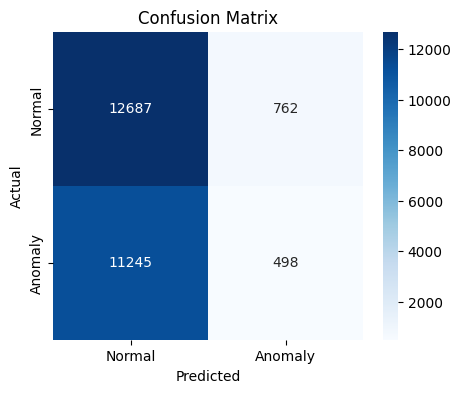

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Top 5% of reconstruction errors as anomalies
threshold = np.percentile(reconstruction_error, 95)
y_pred = (reconstruction_error > threshold).astype(int)

# Metrics
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

# Confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
